# Модель для сервиса по продаже авто

## Описание проекта

### Описание данных

* Сервис по продаже автомобилей с пропегом разрабатывает приложение для привлечения клиентов. В нем можно будет узнать рыночную стоимость своего автомобиля.
* Необходимо постоить модель, которая умеет определять рыночную стоимость автомобиля.
* Даны данные о технических характеристиках, комплектующих и ценах других автомобилей.
* Важные критерии:
    * качество предсказания;
    * время обучения модели;
    * время предсказания модели.

### План

* Загрузка и предобработка данных.
* Обработка аномалий.
* Подготовка выборки к обучению моделей.
* Обучение разных моделей.
* Анализ времени предсказаний, времени обучения и качества моделей.
* Выбор лучшей модели.  

## Инициализация библиотек и констант

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

In [2]:
RANDOM_STATE = 12345

## Загрузка и предобработка данных

### Загрузка и изучение данных

In [3]:
try:
    data = pd.read_csv('../../datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price - цена автомобиля

Не все колонки являются нужными для подсчета стоимости автомобиля. Нужно удалить колонки: DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen, RegistrationMonth.

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


### Анализ и предобработка данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [9]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


In [10]:
data.duplicated().sum()

45040

Дублакаты удалять не будем, возможно это разные машины с одинаковыми признаками.

In [11]:
data.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

In [12]:
data['gearbox'].value_counts()

gearbox
manual    268251
auto       66285
Name: count, dtype: int64

In [13]:
data['repaired'].value_counts()

repaired
no     247161
yes     36054
Name: count, dtype: int64

In [14]:
data[['price', 'registration_year', 'power', 'kilometer']].corr()

,price,registration_year,power,kilometer
price,1.000000,0.026916,0.158872,-0.333199
registration_year,0.026916,1.000000,-0.000828,-0.053447
power,0.158872,-0.000828,1.000000,0.024002
kilometer,-0.333199,-0.053447,0.024002,1.000000


#### Обработка аномалий

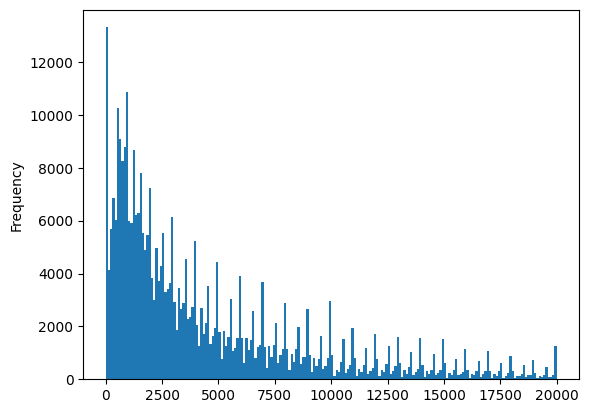

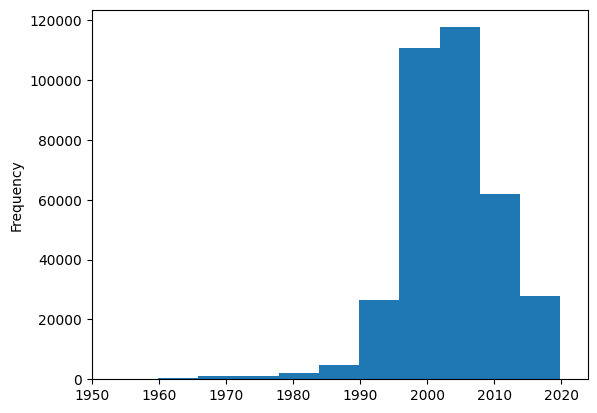

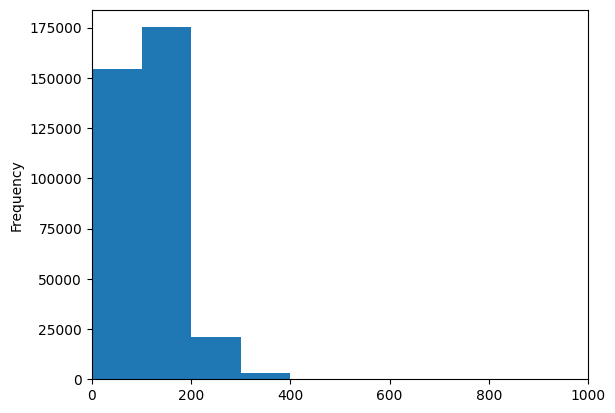

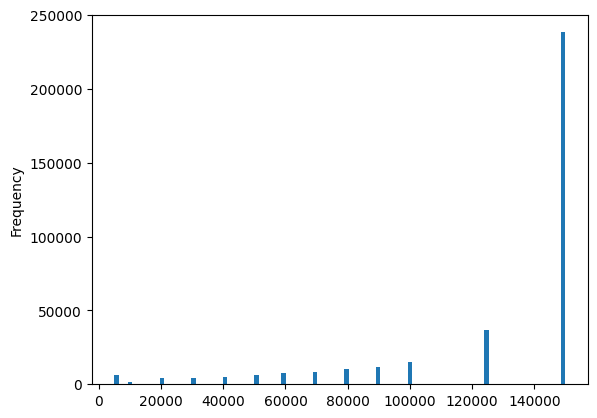

In [15]:
data['price'].plot(kind='hist', bins=200)
plt.show()
data['registration_year'].plot(kind='hist', bins=1500, xlim=(1950, 2024))
plt.show()
data['power'].plot(kind='hist', bins=200, xlim=(0,1000))
plt.show()
data['kilometer'].plot(kind='hist', bins=100)
plt.show()

In [16]:
(
    data[['price', 'registration_year', 'power', 'kilometer']]
    .quantile([0.0012, 0.05, .5, .95, .9988])
    .style.format("{:,.2f}")
)

,price,registration_year,power,kilometer
0.001200,0.00,"1,960.00",0.00,"5,000.00"
0.050000,200.00,"1,992.00",0.00,"40,000.00"
0.500000,"2,700.00","2,003.00",105.00,"150,000.00"
0.950000,"14,600.00","2,016.00",218.00,"150,000.00"
0.998800,"19,999.00","2,018.00",520.00,"150,000.00"


In [17]:
# Удаление аномалий
data = data[data['price'] > 200]
data = data[data['registration_year'] <= 2024]
data = data[(data['power'] > 18) & (data['power'] < 1000)]

In [18]:
(
    data[['price', 'registration_year', 'power', 'kilometer']]
    .quantile([0.0012, 0.05, .5, .95, .9988])
    .style.format("{:,.2f}")
)

,price,registration_year,power,kilometer
0.001200,249.00,"1,965.00",26.00,"5,000.00"
0.050000,500.00,"1,993.00",55.00,"40,000.00"
0.500000,"3,200.00","2,003.00",113.00,"150,000.00"
0.950000,"14,999.00","2,016.00",224.00,"150,000.00"
0.998800,"19,999.00","2,018.00",420.00,"150,000.00"


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301218 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              301218 non-null  int64 
 1   vehicle_type       280945 non-null  object
 2   registration_year  301218 non-null  int64 
 3   gearbox            295519 non-null  object
 4   power              301218 non-null  int64 
 5   model              289446 non-null  object
 6   kilometer          301218 non-null  int64 
 7   fuel_type          282527 non-null  object
 8   brand              301218 non-null  object
 9   repaired           256175 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.3+ MB


#### Обработка пропусков

In [20]:
data.isnull().sum()*100/len(data)

price                 0.000000
vehicle_type          6.730341
registration_year     0.000000
gearbox               1.891985
power                 0.000000
model                 3.908133
kilometer             0.000000
fuel_type             6.205140
brand                 0.000000
repaired             14.953622
dtype: float64

Пропуски в категориальных переменных заполним значением "unknown".

In [21]:
data['vehicle_type'].value_counts()

vehicle_type
sedan          82214
small          67544
wagon          58688
bus            26100
convertible    18688
coupe          14412
suv            10931
other           2368
Name: count, dtype: int64

In [22]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

In [23]:
data['model'].value_counts()

model
golf                  25552
other                 20418
3er                   17639
polo                  10657
corsa                  9947
                      ...  
i3                        5
samara                    5
rangerover                3
serie_3                   3
range_rover_evoque        2
Name: count, Length: 249, dtype: int64

In [24]:
data['model'] = data['model'].fillna('unknown')

In [25]:
data['fuel_type'].value_counts()

fuel_type
petrol      187792
gasoline     89145
lpg           4767
cng            495
hybrid         204
other           81
electric        43
Name: count, dtype: int64

In [26]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

Пропуски в колонках с двумя значениеми заполним предыдущим значением признака.

In [27]:
data['gearbox'].value_counts()

gearbox
manual    235676
auto       59843
Name: count, dtype: int64

In [28]:
data['repaired'].value_counts()

repaired
no     228548
yes     27627
Name: count, dtype: int64

In [29]:
data['gearbox'] = data['gearbox'].ffill()
data['repaired'] = data['repaired'].ffill()

In [30]:
data.isnull().sum()*100/len(data)

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
repaired             0.0
dtype: float64

Пропуски заполнены.

#### Преобразование некоторых колонок к булеву типу

In [31]:
data['gearbox'] = data['gearbox'] == 'auto'
data['repaired'] = data['repaired'] == 'yes'

In [32]:
data['gearbox'].value_counts()

gearbox
False    240208
True      61010
Name: count, dtype: int64

In [33]:
data['repaired'].value_counts()

repaired
False    268806
True      32412
Name: count, dtype: int64

### Вывод по разделу

* Удалены ненужные колонки.
* Названия колонок приведены к нижнему регистру.
* Удалены аномалии в количественных признаках.
* Пропуски в колонках (vehicle_type, model, fuel_type) заполнены заглушкой unknown, а в колонках gearbox и repaired предыдущим значение.
* В колонках gearbox и repaired тип изменен на логический.
* Найдены дубликаты, однако было решено их оставить.

## Подготовка выборки к обучению

### Преобразование категориальных признаков в численные методом OHE

In [34]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,False,190,unknown,125000,gasoline,audi,True
2,9800,suv,2004,True,163,grand,125000,gasoline,jeep,True
3,1500,small,2001,False,75,golf,150000,petrol,volkswagen,False


In [35]:
data['gearbox'] = data['gearbox'].astype(int)
data['repaired'] = data['repaired'].astype(int)
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,0,190,unknown,125000,gasoline,audi,1
2,9800,suv,2004,1,163,grand,125000,gasoline,jeep,1
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0


In [36]:
data_dummies = pd.get_dummies(data, drop_first=True, dtype=int)
data_dummies.head(10)

,price,registration_year,gearbox,power,kilometer,repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
1,18300,2011,0,190,125000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,1,163,125000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,0,75,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,0,69,90000,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,0,102,150000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,2200,2004,0,109,150000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14500,2014,0,125,30000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,999,1998,0,101,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10,2000,2004,0,105,150000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11,2799,2005,0,140,150000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Разбаение выборки на тренировочную и тестовую

In [37]:
features = data_dummies.drop('price', axis=1)
target = data_dummies['price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

### Выводы по разделу

* Категориальные признаки были преобразованы в численные методом прямого кодирования.
* Выборка разбита на тренировочную и тестовую.

## Обучение моделей

In [38]:
# Класс для работы с моделями
class MultiModelLearning:
    def __init__(self, model_name: str):
        self.model_name = model_name
        if model_name == 'linear_regressor':
            self.model = LinearRegression()
        elif model_name == 'tree':
            self.model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        elif model_name == 'bagging':
            self.model = BaggingRegressor(random_state=RANDOM_STATE)
        elif model_name == 'boosting':
            self.model = LGBMRegressor(random_state=RANDOM_STATE)
        elif model_name == 'dummy':
            self.model = DummyRegressor(strategy="mean")
        else:
            display("Было введено неверное имя модели")
        self.features = None
        self.target = None
        self.best_model = None
        self.best_score = None
        self.best_params = None

    # Подбор гиперпараметров для модели
    def select_hyperparameters__(self, param_dist):
        grid_search = GridSearchCV(self.model, param_grid=param_dist, cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(self.features, self.target)
        self.best_model = grid_search.best_estimator_
        self.hyperparameters = grid_search.best_params_
        self.best_score = -grid_search.best_score_

    # Функции обучения моделей
    def learn_linear_regression__(self): 
        self.best_score = -sum(cross_val_score(self.model, self.features, self.target, cv=5, scoring='neg_root_mean_squared_error'))/5
    
    def learn_tree__(self):
        param_dist = {
            'max_depth': [i for i in range(1,15)]
        }
        self.select_hyperparameters__(param_dist)

    def learn_bagging__(self):
        param_dist = {
            'n_estimators': [i for i in range(1, 8)],
        }
        self.select_hyperparameters__(param_dist)
        
    def learn_boosting__(self):
        param_dist = {
            'n_estimators': [2,5,10],
        }
        self.select_hyperparameters__(param_dist)

    def learn_dummy__(self):
        self.best_model = self.model.fit(self.features, self.target)
        self.best_score = -sum(cross_val_score(self.model, self.features, self.target, cv=5, scoring='neg_root_mean_squared_error'))/5


    def select_model__(self):
        if self.model_name == 'linear_regressor':
            self.learn_linear_regression__()
        elif self.model_name == 'tree':
            self.learn_tree__()
        elif self.model_name == 'bagging':
            self.learn_bagging__()
        elif self.model_name == 'boosting':
            self.learn_boosting__()
        elif self.model_name == 'dummy':
            self.learn_dummy__()
        else:
            display("Было введено неверное имя модели")

    def fit(self, features, target):
        self.features = features
        self.target = target
        self.select_model__()


    # Предсказание модели
    def predict(self, features):
        model_predictions = self.best_model.predict(features)
        return model_predictions

### Обучение линейной решнессии

In [39]:
linear_regression = MultiModelLearning('linear_regressor')
linear_regression.fit(features_train, target_train)
linear_regression.best_score

2736.237988300075

### Обучение дерева решений

In [40]:
tree = MultiModelLearning('tree')
tree.fit(features_train, target_train)
tree.best_score

1898.0769457248148

### Обучение бэггинга

In [41]:
bagging = MultiModelLearning('bagging')
bagging.fit(features_train, target_train)
bagging.best_score

1682.2882308341618

### Обучение бустинга

In [42]:
boosting = MultiModelLearning('boosting')
boosting.fit(features_train, target_train)
boosting.best_score

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 180730, number of used features: 287
[LightGBM] [Info] Start training from score 4892.563327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 180730, number of used features: 286
[LightGBM] [Info] Start training from score 4896.355414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

2642.513856323163

### Вывод по разделу

* Модели удовлетворяющие условиям заказчика: бэггинг и дерево решений со значениями RMSE 1682 и 1898 соответственно.
* Время обучения бэггинга - 6 минуты, дерева решений - 2 минуты.

## Анализ качества моделей

### Скорость работы моделей

In [43]:
bagging.predict(features_train)

array([4172.59174159, 5740.66354952, 4178.57142857, ..., 9113.77800454,
       5149.92653061, 6779.12857143])

In [44]:
tree.predict(features_train)

array([4409.5015873 , 6412.79931973, 5472.04489796, ..., 9574.23684211,
       5134.73692308, 6652.42215256])

Бэггинг формирует предсказание 3 секунды, а решающее деверо 0.2 секунды

### Проверка лучшей модели на тестовой выборке

In [45]:
tree_predict = tree.predict(features_test)
root_mean_squared_error(target_test, tree_predict)

1869.1120004245029

### Проверка модели на адекватность

In [46]:
dummy = MultiModelLearning('dummy')
dummy.fit(features_train, target_train)
dummy.best_score

4589.579040538546

### Выводы по качеству моделей и выбор лучшей

* Под критерий "Значение метрики RMSE должно быть меньше 2500" подходят модил бэггинга и решающего дерева со значениями RMSE 1682 и 1898 соответственно.
* Время обучения бэггинга - 6 минут, дерева решений - 2 минуты (включая подбор параметров).
* Скорость работы дерева решений 0.2с, бэггинга - 2.9с.
* Так как заказчику важно и значение метрики RMSE, и время обучения модели, и время ее работы лучшая модель из обученных - решающее дерево. Эта модель быстрее всего учится и работает и при этом имеет приемлимое значение метрики RMSE.
* Решающее дерево также себя хорошо показывает на тестовых данных.

## Общий вывод

* Предобработка и анализ данных: 

    * Удалены ненужные колонки.
    * Удалены аномалии в количественных признаках.
    * Пропуски в колонках (vehicle_type, model, fuel_type) заполнены заглушкой unknown, а в колонках gearbox и repaired предыдущим значение.
    * Найдены дубликаты, однако было решено их оставить. 
    * Категориальные признаки были преобразованы в численные методом прямого кодирования для обучения моделей.
    * Выборка была разбита на обучающую и тестовую.
    
* Обучение моделей:

    * Были обучены модели: решающего дерева, линейной регрессии, бэггинга и бустинга.
    * Под критерий "Значение метрики RMSE должно быть меньше 2500" подходят модил бэггинга и решающего дерева со значениями RMSE 1682 и 1898 соответственно.
    * Время обучения бэггинга - 6 минут, дерева решений - 2 минуты (включая подбор параметров).
    * Скорость работы дерева решений 0.2с, бэггинга - 2.9с.
    * Лучшая модель из обученных - решающее дерево. Эта модель быстрее всего учится и работает и при этом имеет приемлимое значение метрики RMSE.
    * Решающее дерево также себя хорошо показывает на тестовых данных.
    * Также была проведена проверка на адекватность модели посредством сравнения ее RMSE c RMSE DummyRegressor, которую прошли все модели.

* Общий итог:

    * На основе полученных данных была создана модель, предсказывающая цену на автомобиль по вводимым пользователем признакам с погрешностью меньше 2500. 
    * Время обучения этой модели составило 2 минуты а скорость работы 0.2 секунды.